In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Get mapbox API key
from dotenv import dotenv_values
mapbox_access_token = dotenv_values(".env")['MAPBOX_API']

### Objective 1: 
To investigate the bus system with a focus on identifying capacity (dispatch) and demand (ridership) patterns in Singapore.

In [12]:
# Read the data
bus = pd.read_csv('./data/bus_demand_and_capacity.csv')
bus_demand = pd.read_csv('./data/bus_demand_high_LOD.csv')
bus_stops = pd.read_csv('./datasrc/bus_stops.csv')

In [13]:
display(bus[bus['ServiceNo']=='991A'])

ServiceNo  Direction  StopSequence Operator  BusStopCode  Distance  \
25869      991A          1             1     SMRT        43009       0.0   
25870      991A          1             2     SMRT        43419       0.4   
25871      991A          1             3     SMRT        43401       0.8   
25872      991A          1             4     SMRT        43321       1.2   
25873      991A          1             5     SMRT        43331       1.5   
25874      991A          1             6     SMRT        43341       1.8   

                  RoadName             Description  Latitude   Longitude  ...  \
25869        Bt Batok Ctrl            Bt Batok Int  1.349994  103.751062  ...   
25870        Bt Batok Ctrl                 Blk 628  1.351555  103.749988  ...   
25871  Bt Batok West Ave 3     Bt Batok Polyclinic  1.352265  103.746816  ...   
25872  Bt Batok West Ave 6             Opp Blk 144  1.349906  103.745109  ...   
25873       Bt Batok St 11  Opp Bt Batok Presby Ch  1.348939  103.743234  ...   
25874  Bt Batok West Ave 3       Princess E Pr Sch  1.349722  103.741393  ...   

      Weekday_Monthly_TapIn_PM_Offpeak  Weekend/Hols_Monthly_TapIn_PM_Offpeak  \
25869                            847.0                                 1181.0   
25870                           1373.0                                  601.0   
25871                            276.0                                  110.0   
25872                            216.0                                   80.0   
25873                            214.0                                   76.0   
25874                            328.0                                  135.0   

       Weekday_Monthly_TapOut_AM_Peak Weekend/Hols_Monthly_TapOut_AM_Peak  \
25869                             0.0                              2452.0   
25870                             0.0                               905.0   
25871                          1410.0                               273.0   
25872                           641.0                               267.0   
25873                           691.0                               240.0   
25874                          1079.0                               126.0   

       Weekday_Monthly_TapOut_AM_Offpeak  \
25869                                0.0   
25870                             2445.0   
25871                             1246.0   
25872                              647.0   
25873                              741.0   
25874                              585.0   

       Weekend/Hols_Monthly_TapOut_AM_Offpeak  Weekday_Monthly_TapOut_PM_Peak  \
25869                                     0.0                             0.0   
25870                                  1368.0                             0.0   
25871                                   354.0                          1157.0   
25872                                   311.0                           875.0   
25873                                   340.0                          1335.0   
25874                                   208.0                           825.0   

       Weekend/Hols_Monthly_TapOut_PM_Peak  Weekday_Monthly_TapOut_PM_Offpeak  \
25869                                  0.0                              377.0   
25870                               1477.0                              904.0   
25871                                341.0                              434.0   
25872                                270.0                              277.0   
25873                                360.0                              348.0   
25874                                214.0                              299.0   

       Weekend/Hols_Monthly_TapOut_PM_Offpeak  
25869                                   561.0  
25870                                   452.0  
25871                                   182.0  
25872                                   124.0  
25873                                   129.0  
25874                                   127.0  

[6 rows x 34 co

In [14]:
print(bus['Category'].unique())


['TRUNK' 'EXPRESS' 'NIGHT SERVICE' 'FEEDER' 'INDUSTRIAL' 'TOWNLINK'
 'FLAT FARE $2.70' 'FLAT FARE $3.50' 'FLAT FARE $5.00' 'FLAT FARE $4.20'
 'FLAT FARE $4.50' 'FLAT FARE $4.00' 'CITY_LINK' 'FLAT FARE $2.00'
 'NIGHT RIDER']


In [15]:
# Get bus with category of Trunk,Express,Feeder drop everything else
bus = bus[bus['Category'].isin(['TRUNK','EXPRESS','FEEDER'])]


### Chart 1
Violin Plot of number of bus dispatched at different times of the day

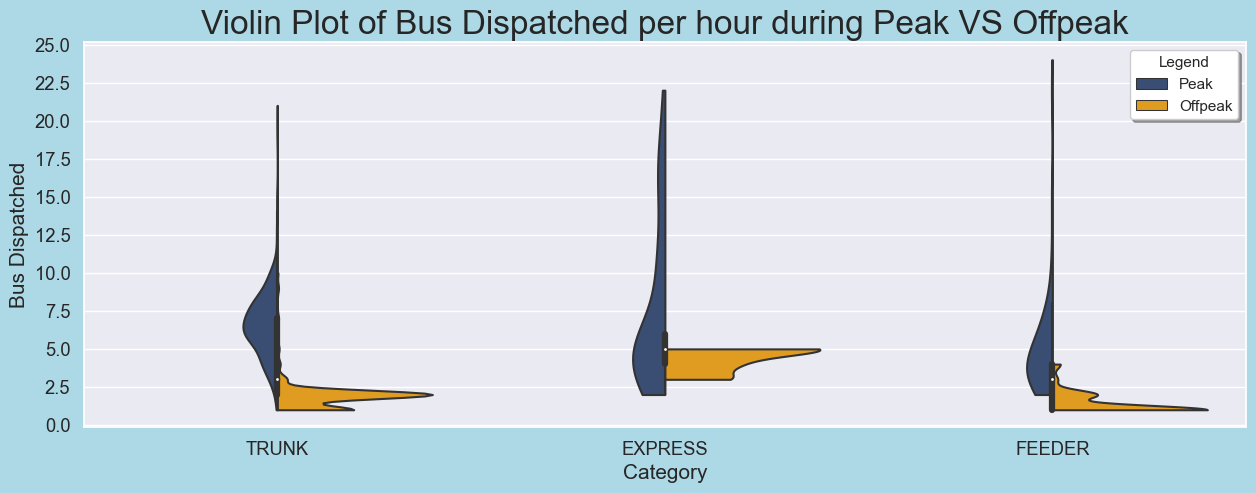

In [16]:
df = bus.copy()

# Group by routes
df = df.groupby(['ServiceNo','Direction']).agg({'AM_Peak_avg':'mean','PM_Peak_avg':'mean','AM_Offpeak_avg':'mean','PM_Offpeak_avg':'mean', 'Category':'first'}).reset_index()

# Convert it to bus dispatched per hour instead of total bus dispatched
df['Peak_Dispatch'] = (df['AM_Peak_avg'] + df['PM_Peak_avg'])//(3)
df['Offpeak_Dispatch'] = (df['AM_Offpeak_avg'] + df['PM_Offpeak_avg'])//(11)

df = df[['ServiceNo','Direction','Category','Peak_Dispatch','Offpeak_Dispatch']]

# Dropna
df = df.dropna()

# Convert from wide to long
df = pd.melt(df, id_vars=['ServiceNo','Direction','Category'], value_vars=['Peak_Dispatch','Offpeak_Dispatch'], var_name='Peak', value_name='Dispatch')
# Drop all 0
df = df[df['Dispatch']!=0]

# Plot Graph
fig, ax = plt.subplots(figsize=(15,5))

sns.violinplot(x='Category', y='Dispatch', data=df, hue='Peak', cut=0, split=True, palette=sns.color_palette(["#2f4b7c", "#ffa600"]), ax=ax)

# Edit the style
sns.set(style="darkgrid", rc={'figure.facecolor':'lightblue'}, font_scale=1.2)

# Edit the legend
ax.legend(loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')

# Edit legend values
ax.get_legend().get_texts()[0].set_text('Peak')
ax.get_legend().get_texts()[1].set_text('Offpeak')

# Edit x and y labels
ax.set_xlabel('Category', fontsize=15)
ax.set_ylabel('Bus Dispatched', fontsize=15)

# Edit y axis
ax.set_yticks(np.arange(0, 26, 2.5))

# Edit the title
ax.set_title('Violin Plot of Bus Dispatched per hour during Peak VS Offpeak', fontsize=24)

# Offpeak not lot of bus for express and feeder (with 0 being the mode)
# This suggest that express and feeder are not dispatched as much during offpeak

plt.show()

### Chart 2
Reg Plot during different time (AM Peak, PM Peak, AM Offpeak, PM Offpeak) between total number of ridership per route (sum of tap in) and number of bus dispatched

In [17]:
df = bus.copy()

# Get Mean Bus Dispatched per Route
category = df.groupby(['ServiceNo','Direction']).agg({'Category':'first', 'AM_Peak_avg' : 'mean', 'PM_Peak_avg' : 'mean', 'AM_Offpeak_avg' : 'mean', 'PM_Offpeak_avg' : 'mean'}).reset_index()

# Change column name of distance to distance per route
category = category.rename(columns={'AM_Peak_avg':'AM_Peak_Dispatch', 'PM_Peak_avg':'PM_Peak_Dispatch', 'AM_Offpeak_avg':'AM_Offpeak_Dispatch', 'PM_Offpeak_avg':'PM_Offpeak_Dispatch'})

df = df.groupby(['ServiceNo','Direction']).sum().reset_index()
df = df.merge(category, on=['ServiceNo','Direction'])
df = df.dropna()

# Reformat data
df['Weekday_Peak_Tap_In'] = (df['Weekday_Monthly_TapIn_AM_Peak'] + df['Weekday_Monthly_TapIn_PM_Peak'])
df['Weekday_Offpeak_Tap_In'] = (df['Weekday_Monthly_TapIn_AM_Offpeak'] + df['Weekday_Monthly_TapIn_PM_Offpeak'])
df['Weekend_Peak_Tap_In'] = (df['Weekend/Hols_Monthly_TapIn_AM_Peak'] + df['Weekend/Hols_Monthly_TapIn_PM_Peak'])
df['Weekend_Offpeak_Tap_In'] = (df['Weekend/Hols_Monthly_TapIn_AM_Offpeak'] + df['Weekend/Hols_Monthly_TapIn_PM_Offpeak'])

df['Peak_Dispatch'] = (df['AM_Peak_Dispatch'] + df['PM_Peak_Dispatch'])//2
df['Offpeak_Dispatch'] = (df['AM_Offpeak_Dispatch'] + df['PM_Offpeak_Dispatch'])//8

df = df[['ServiceNo','Direction','Category','Peak_Dispatch','Offpeak_Dispatch','Weekday_Peak_Tap_In','Weekday_Offpeak_Tap_In','Weekend_Peak_Tap_In','Weekend_Offpeak_Tap_In']]

# Remove outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
left = Q1 - 1.5 * IQR
right = Q3 + 1.5 * IQR
df = df[(df >= left) & (df <= right)]

C:\Users\ryany\AppData\Local\Temp\ipykernel_29980\106328348.py:30: FutureWarning:

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`



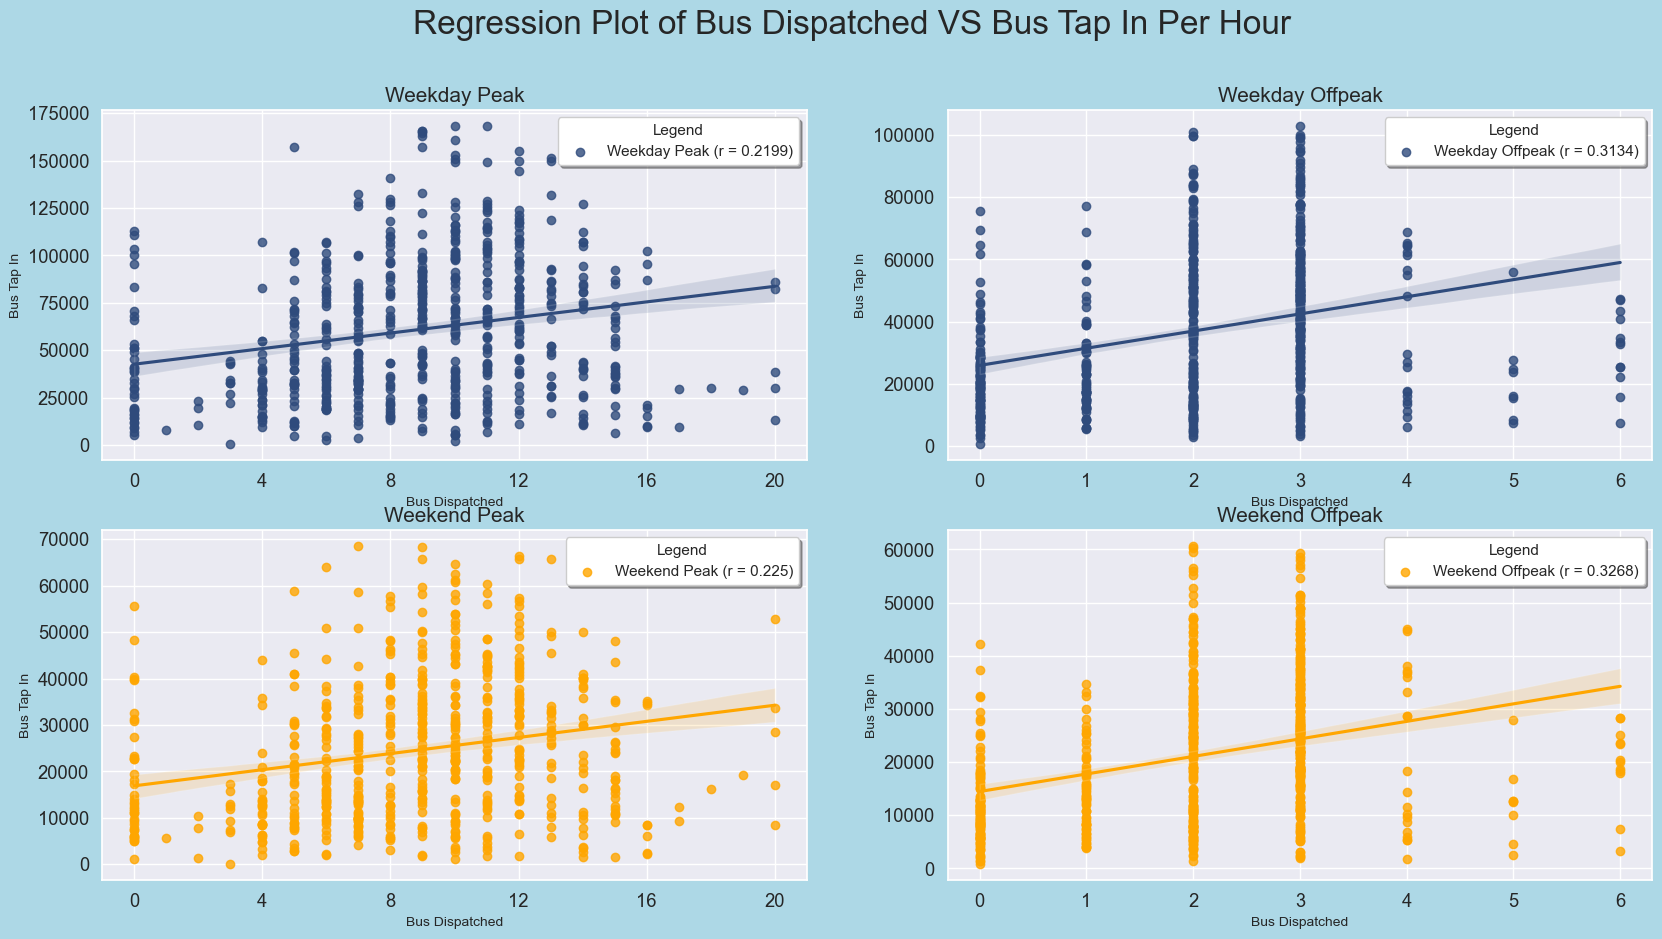

In [18]:
# Plot Four Regression Plots in Seaborn
fig, ax = plt.subplots(2,2, figsize=(20,10))

# Weekday Peak
sns.regplot(x='Peak_Dispatch', y='Weekday_Peak_Tap_In', data=df, ax=ax[0,0], color='#2f4b7c')
ax[0,0].set_title('Weekday Peak', fontsize=15)
ax[0,0].set_xlabel('Bus Dispatched', fontsize=10)
ax[0,0].set_ylabel('Bus Tap In', fontsize=10)
ax[0,0].set_xticks(np.arange(0, 21,4))

# Weekday Offpeak
sns.regplot(x='Offpeak_Dispatch', y='Weekday_Offpeak_Tap_In', data=df, ax=ax[0,1], color='#2f4b7c')
ax[0,1].set_title('Weekday Offpeak', fontsize=15)
ax[0,1].set_xlabel('Bus Dispatched', fontsize=10)
ax[0,1].set_ylabel('Bus Tap In', fontsize=10)

# Weekend Peak
sns.regplot(x='Peak_Dispatch', y='Weekend_Peak_Tap_In', data=df, ax=ax[1,0], color='#ffa600')
ax[1,0].set_title('Weekend Peak', fontsize=15)
ax[1,0].set_xlabel('Bus Dispatched', fontsize=10)
ax[1,0].set_ylabel('Bus Tap In', fontsize=10)
ax[1,0].set_xticks(np.arange(0, 21,4))

# Weekend Offpeak
sns.regplot(x='Offpeak_Dispatch', y='Weekend_Offpeak_Tap_In', data=df, ax=ax[1,1], color='#ffa600')
ax[1,1].set_title('Weekend Offpeak', fontsize=15)
ax[1,1].set_xlabel('Bus Dispatched', fontsize=10)
ax[1,1].set_ylabel('Bus Tap In', fontsize=10)

# Edit the style
sns.set(style="darkgrid", rc={'figure.facecolor':'lightblue'}, font_scale=1.2)

# Add overall title
fig.suptitle('Regression Plot of Bus Dispatched VS Bus Tap In Per Hour', fontsize=24)

# Add legend for each subplot
ax[0,0].legend(['Weekday Peak'], loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# Include r-value
ax[0,0].get_legend().get_texts()[0].set_text(f'Weekday Peak (r = {round(df["Weekday_Peak_Tap_In"].corr(df["Peak_Dispatch"]),4)})')

ax[0,1].legend(['Weekday Offpeak'], loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# Include r-value
ax[0,1].get_legend().get_texts()[0].set_text(f'Weekday Offpeak (r = {round(df["Weekday_Offpeak_Tap_In"].corr(df["Offpeak_Dispatch"]),4)})')

ax[1,0].legend(['Weekend Peak'], loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# Include r-value
ax[1,0].get_legend().get_texts()[0].set_text(f'Weekend Peak (r = {round(df["Weekend_Peak_Tap_In"].corr(df["Peak_Dispatch"]),4)})')

ax[1,1].legend(['Weekend Offpeak'], loc='upper right', title='Legend', title_fontsize=11, fontsize=11, shadow=True, facecolor='white')
# Include r-value
ax[1,1].get_legend().get_texts()[0].set_text(f'Weekend Offpeak (r = {round(df["Weekend_Offpeak_Tap_In"].corr(df["Offpeak_Dispatch"]),4)})')

plt.show()

### Chart 3
Heatmap of Tap In to Tap Out ratio at different bus stops in Singapore during different time

In [19]:
df = bus.copy()

df['Weekday_Peak_Ratio'] = ((df['Weekday_Monthly_TapIn_AM_Peak']/df['Weekday_Monthly_TapOut_AM_Peak'])*3 + (df['Weekday_Monthly_TapIn_PM_Peak']/df['Weekday_Monthly_TapOut_PM_Peak'])*2)/5
df['Weekday_OffPeak_Ratio'] = ((df['Weekday_Monthly_TapIn_AM_Offpeak']/df['Weekday_Monthly_TapOut_AM_Offpeak'])*8 + (df['Weekday_Monthly_TapIn_PM_Offpeak']/df['Weekday_Monthly_TapOut_PM_Offpeak'])*10)/18
df['Weekend/Hols_Peak_Ratio'] = ((df['Weekend/Hols_Monthly_TapIn_AM_Peak']/df['Weekend/Hols_Monthly_TapOut_AM_Peak'])*3 + (df['Weekend/Hols_Monthly_TapIn_PM_Peak']/df['Weekend/Hols_Monthly_TapOut_PM_Peak'])*2)/5
df['Weekend/Hols_OffPeak_Ratio'] = ((df['Weekend/Hols_Monthly_TapIn_AM_Offpeak']/df['Weekend/Hols_Monthly_TapOut_AM_Offpeak'])*8 + (df['Weekend/Hols_Monthly_TapIn_PM_Offpeak']/df['Weekend/Hols_Monthly_TapOut_PM_Offpeak'])*10)/18

df['Weekday_Peak_Ratio'] = df['Weekday_Peak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekday_Peak_Ratio'].quantile(0.25)
q3 = df['Weekday_Peak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekday_Peak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekday_Peak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekday_OffPeak_Ratio'] = df['Weekday_OffPeak_Ratio'].dropna()
# Drop outliers using IQR   
q1 = df['Weekday_OffPeak_Ratio'].quantile(0.25)
q3 = df['Weekday_OffPeak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekday_OffPeak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekday_OffPeak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekend/Hols_Peak_Ratio'] = df['Weekend/Hols_Peak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekend/Hols_Peak_Ratio'].quantile(0.25)
q3 = df['Weekend/Hols_Peak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekend/Hols_Peak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekend/Hols_Peak_Ratio'] <= q3 + 1.5*iqr)]

df['Weekend/Hols_OffPeak_Ratio'] = df['Weekend/Hols_OffPeak_Ratio'].dropna()
# Drop outliers using IQR
q1 = df['Weekend/Hols_OffPeak_Ratio'].quantile(0.25)
q3 = df['Weekend/Hols_OffPeak_Ratio'].quantile(0.75)
iqr = q3 - q1
df = df[(df['Weekend/Hols_OffPeak_Ratio'] >= q1 - 1.5*iqr) & (df['Weekend/Hols_OffPeak_Ratio'] <= q3 + 1.5*iqr)]

df = df[['Latitude','Longitude','Weekday_Peak_Ratio','Weekday_OffPeak_Ratio','Weekend/Hols_Peak_Ratio','Weekend/Hols_OffPeak_Ratio']]

bus_190 = bus[bus['ServiceNo']=='190']
bus_65 = bus[bus['ServiceNo']=='65']

In [20]:
# Create figure object
fig = go.Figure()

# Trace 1 - Density Heatmap
fig.add_trace(go.Densitymapbox(lat=df['Latitude'], lon=df['Longitude'], z=df['Weekday_Peak_Ratio'],
                                 radius=5, zmin = df['Weekday_Peak_Ratio'].min(), zmax = 8,
                                 colorscale='Viridis',colorbar={'title':'Ratio'},name='Ratio'))

# Trace 2 - Add bus route 65
fig.add_trace(go.Scattermapbox(
    lat=bus_65['Latitude'],
    lon=bus_65['Longitude'],
    mode='lines',
    line=dict(width=2, color='red'),
    name='Bus Route 65',
    showlegend=True,
    visible='legendonly'
))

# Trace 3 - Add bus route 190
fig.add_trace(go.Scattermapbox(
    lat=bus_190['Latitude'],
    lon=bus_190['Longitude'],
    mode='lines',
    line=dict(width=2, color='blue'),
    name='Bus Route 190',
    showlegend=True,
    visible='legendonly'
))

# Create layout
fig.update_layout(mapbox=dict(
                    accesstoken=mapbox_access_token,
                    # Light: carto-positron, Dark: carto-darkmatter
                    style="carto-positron",
                    center = dict(lat=df['Latitude'].mean(), lon=df['Longitude'].mean()),
                    zoom=10),
                  margin={"r":10,"t":0,"l":0,"b":0})

# Add title and subtitle
fig.update_layout(
    title={
        'text': "Tap In/Tap Out Ratio of Bus Stops",
        'y':0.98,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    titlefont=dict(
        size=30)
)               

# Create menus
fig.update_layout(
    updatemenus=[
        # Add dropdown
        dict(
            buttons=list([
                dict(
                    args=[{'z': [df["Weekday_Peak_Ratio"]]}],
                    label="Tap In/Tap Out Ratio during Weekday Peak hours",
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df["Weekday_OffPeak_Ratio"]]}],
                    label='Tap In/Tap Out Ratio during Weekday Offpeak hours',
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df["Weekend/Hols_Peak_Ratio"]]}],
                    label='Tap In/Tap Out Ratio during Public Holiday Peak Hours',
                    method="restyle"
                ),
                dict(
                    args=[{'z': [df['Weekend/Hols_OffPeak_Ratio']]}],
                    label='Tap In/Tap Out Ratio during Public Holiday Offpeak Hours',
                    method="restyle"
                )
            ]),
            direction="down",
            pad={"r": 10, "t": 0},
            showactive=True,
            x=0,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
        # Buttons for bus routes
        dict(
            type="buttons",
            buttons=list([
                # First button for neither bus routes
                dict(
                    args=[{'visible':'legendonly'},[1,2]],
                    label='None',
                    method="restyle"
                ),
                # Second button for bus route 65
                dict(
                    args=[{'visible':True},[1]],
                    args2=[{'visible':'legendonly'},[1]],
                    label="Bus Route 65",
                    method="restyle"
                ),
                # Third button for bus route 190
                dict(
                    args=[{'visible':True},[2]],
                    args2=[{'visible':'legendonly'},[2]],
                    label='Bus Route 190',
                    method="restyle"
                ),
                # Fourth button for both bus routes
                dict(
                    args=[{'visible':True},[1,2]],
                    args2=[{'visible':'legendonly'},[1,2]],
                    label="Both Bus Routes",
                    method="restyle"
                )
            ]),
            direction="right",
            pad={"r": 30, "t": 0},
            showactive=True,
            x=0.38,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ]
)

# Make legends not overlap
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.15,
    xanchor="right",
    x=1.1
))

fig.show()
# An explanation of the plot is found in chart3.md

### Objective 2: